## Real or Not? NLP with Disaster Tweets - Project 2 - Sam's part

Big-Scale Analytics - Project 2 - Team Rolex
> Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller

## Load dataset

In [181]:
import pandas as pd

In [182]:
train = pd.read_csv ('../data/train.csv')
train = train[['id', 'text', 'target']]

test = pd.read_csv ('../data/test.csv')
test = test[['id', 'text']]

train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [183]:
total_count = 0
for row in train.iterrows():
  total_count += 1
print(f'there are {total_count} tweets in the dataset')

train_yes = train.query('target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'there are {yes_count} tweets about disasters')

train_no = train.query('target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'there are {no_count} tweets that are not about disasters')

print('the classification base rate is ' + str(yes_count/(yes_count+no_count)*100)[:5] + '%')

there are 7613 tweets in the dataset
there are 3271 tweets about disasters
there are 4342 tweets that are not about disasters
the classification base rate is 42.96%


# Text processing

In [184]:
#!pip install spacy
#!python -m spacy download en

## Import libraries

In [185]:
import string
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk

parser = English()
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation


## Lowercase and remove punctuation

In [186]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
  
  
train['filtered_tweet'] = train['text'].apply(lambda x: clean_text(x))
test['filtered_tweet'] = test['text'].apply(lambda x: clean_text(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


## Tokenize tweets

In [187]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: tokenizer.tokenize(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: tokenizer.tokenize(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


## Remove stopwords and punctuation

In [188]:
# remove stopwords and punctuation
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords.words('english')]
    text = [word for word in text if word not in punctuations]
    
    return text

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: remove_stopwords(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: remove_stopwords(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


## Recreate sentences

In [189]:
def sentence(text):
  sentence = ''
  for word in text:
    sentence = sentence + ' ' + word
  
  return sentence

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: sentence(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: sentence(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified office...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders ca...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires po...


# Classification models

## Logistic regression

In [190]:
#!python -m spacy download en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### Tokenize tweets

In [191]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() 
                if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens 
                if word not in stop_words and word not in punctuations ]

    return mytokens


tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

### Split train/test sets (from train dataset)

In [192]:
X = train['filtered_tweet']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72)

### Run logistic regression

In [193]:
classifier = LogisticRegression(solver="lbfgs")

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

0.8069176882661997


In [194]:
print(f'For a train/test split treshold of 0.3: \n')

print(f'We can see here that our model identified a tweet about a disaster {str(accuracy*100)[:4]}% of the time. \n')

print(f'When it predicted a tweet to be about a disaster, it was correctly assessed {str(precision[0]*100)[:4]}% of the time, \nand was correctly assessed for a tweet not about a disaster {str(precision[1]*100)[:4]}% of the time. \n')

print(f'When given a tweet about a disaster, the model considered it as being about a disaster {str(recall[0]*100)[:4]}% of the time, \nand when given a tweet not about a disaster the model considered it as not a disaster for {str(recall[1]*100)[:4]}% of the time. \n')

For a train/test split treshold of 0.3: 

We can see here that our model identified a tweet about a disaster 80.6% of the time. 

When it predicted a tweet to be about a disaster, it was correctly assessed 77.9% of the time, 
and was correctly assessed for a tweet not about a disaster 86.1% of the time. 

When given a tweet about a disaster, the model considered it as being about a disaster 91.7% of the time, 
and when given a tweet not about a disaster the model considered it as not a disaster for 66.3% of the time. 



### Plot the results for different levels of train/test split treshold

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

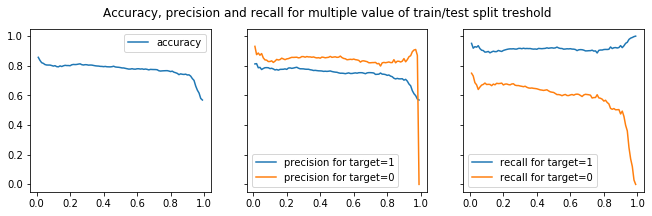

In [195]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predicted)
  precision = metrics.precision_score(y_test, predicted, average=None)
  recall = metrics.recall_score(y_test, predicted, average=None)
  
  data_acc[j] = accuracy
  data_prec[j] = precision
  data_rec[j] = recall
  
names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [196]:
print('From those graphs, we can see that the optimal train/test split treshold seems to be around 0.3.')

From those graphs, we can see that the optimal train/test split treshold seems to be around 0.3.


### Test the model on the testing dataset

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72)

X_test = test['filtered_tweet']



pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


### Create submission file

In [198]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission.csv',index=False)

## Neural networks

### Vectorizing tweets

In [199]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", 
                stop_words=None, ngram_range=(2,2), analyzer='word')

# Vectorize the training set
X_train = word_vectorizer.fit_transform(train['filtered_tweet'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.fit_transform(test['filtered_tweet'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is a disaster tweet
y_train = train['target']


print('train input shape: ', X_train.shape)
print('train output shape: ', y_train.shape)
print('test output shape: ', X_test.shape)

train input shape:  (7613, 867)
train output shape:  (7613,)
test output shape:  (3263, 814)


### Building the model

In [200]:
#!pip install -U protobuf==3.8.0

In [201]:
#!pip install --upgrade tensorflow

In [202]:
#!pip install keras

In [203]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

In [204]:
model = Sequential()
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.

model.add(Dropout(0.2))# Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(7613, input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

In [205]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [206]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 7613)              6608084   
_________________________________________________________________
activation_31 (Activation)   (None, 7613)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7613)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 7613)              57965382  
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 7614      
Total params: 64,581,080
Trainable params: 64,581,080
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [207]:
model_hist = model.fit(X_train, y_train,
                       batch_size=1000, epochs=20,
                       verbose=1, validation_split=0.3)

Train on 5329 samples, validate on 2284 samples
Epoch 1/20
5329/5329 [==============================] - 25s 5ms/step - loss: 0.6920 - accuracy: 0.5573 - val_loss: 0.6834 - val_accuracy: 0.5762
Epoch 2/20
5329/5329 [==============================] - 24s 5ms/step - loss: 0.6679 - accuracy: 0.6221 - val_loss: 0.6634 - val_accuracy: 0.6506
Epoch 3/20
5329/5329 [==============================] - 25s 5ms/step - loss: 0.6409 - accuracy: 0.6799 - val_loss: 0.6456 - val_accuracy: 0.6729
Epoch 4/20
5329/5329 [==============================] - 25s 5ms/step - loss: 0.6175 - accuracy: 0.7005 - val_loss: 0.6323 - val_accuracy: 0.6751
Epoch 5/20
5329/5329 [==============================] - 25s 5ms/step - loss: 0.5985 - accuracy: 0.7076 - val_loss: 0.6228 - val_accuracy: 0.6651
Epoch 6/20
5329/5329 [==============================] - 24s 5ms/step - loss: 0.5838 - accuracy: 0.7138 - val_loss: 0.6167 - val_accuracy: 0.6721
Epoch 7/20
5329/5329 [==============================] - 24s 5ms/step - loss: 0.572

### Evaluate performance

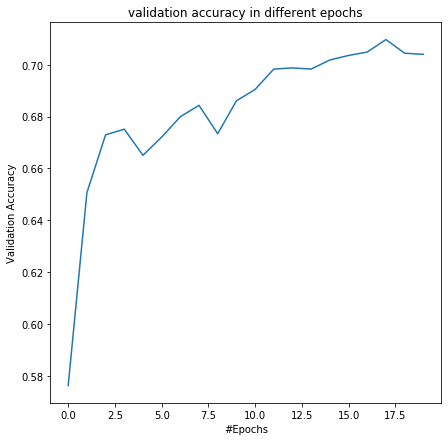

In [208]:
plt.figure(figsize=(7,7))
plt.plot(model_hist.history['val_accuracy'])
plt.xlabel("#Epochs")
plt.ylabel("Validation Accuracy")
plt.title("validation accuracy in different epochs")
plt.show()

### Predict for test dataset

In [209]:
y_test = model.predict_classes(X_test[0])

ValueError: Error when checking input: expected dense_57_input to have shape (867,) but got array with shape (814,)

In [ ]:
y_test.shape